In [1]:
from math import sqrt
from math import floor
from scipy import optimize
from skimage import data
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn.cluster import AffinityPropagation
from sklearn.neighbors import KDTree
from numpy import pi, r_
import matplotlib.pyplot as plt
import numpy as np
import math, random, sys
sys.path.insert(0, '../../FISH-annotation/Annotation')
import util

In [2]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

# Chemistry parameters

In [3]:
optimal_threshold = 0.06

img_path = 'rca.png'
im = imread(img_path)
im = rgb2gray(im)

img_height, img_width = 2048, 2048

coords_path = 'rca.csv'

In [4]:
margin = 4					# margin around each spot, in pixels
thresholds = np.arange(0.02, 0.18, 0.005)
correctness_threshold = 4

# Run blob detection
Use the optimal intensity threshold (threshold = 0.6) found in `blob_log_smFISH_auto_detect_best_intensity_threshold.ipynb`.

In [5]:
blobs_log = blob_log(im, max_sigma=10, num_sigma=10, threshold=optimal_threshold)

# Visualize blobs found by blobs_log()

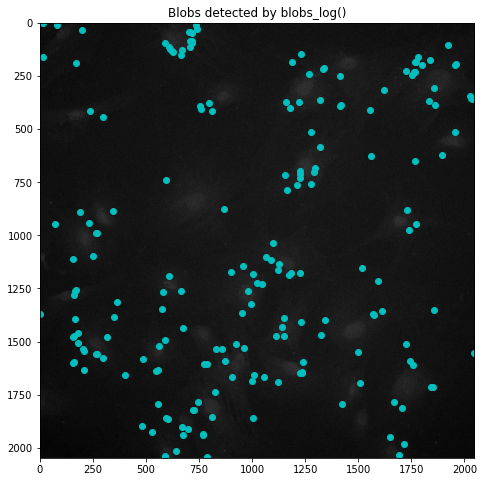

In [6]:
blobs_list = []
for r, c, sigma in blobs_log:
    blobs_list.append([c, r])

plt.figure(figsize = (12, 8))
for c, r in blobs_list:
    plt.scatter([int(c)], [int(r)], c='c')
plt.imshow(im, cmap='gray')
plt.title('Blobs detected by blobs_log()')
plt.show()

### For comparison, these are the blobs that were found by the expert:

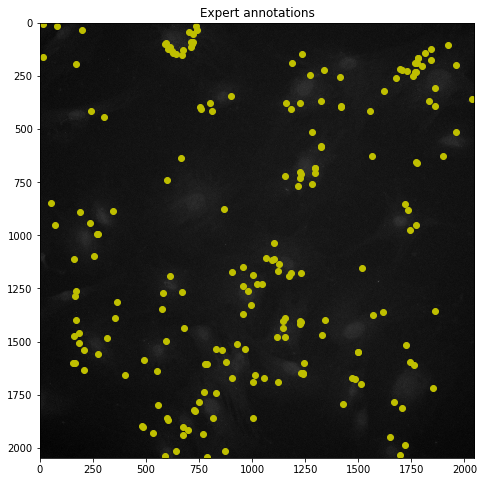

In [7]:
plt.figure(figsize = (12, 8))
coords = np.genfromtxt(coords_path, delimiter=',')
for coord in coords:
    plt.scatter(coord[0], coord[1], facecolors = 'y')
plt.title('Expert annotations')
plt.imshow(im, cmap='gray')
plt.show()

# Bound crowded regions using blobs found by blobs_log()

## Approach
1. Identify all crowded spots. Crowded spots are less than a crosshair arm length from the nearest neighbor.
2. Separate regions with many crowded spots.
3. Define a bounding box around each region with many crowded spots.

## Goal 1: Identify crowded spots.

Highlight spots which are too close to (i.e. less than an crosshair arm length from) the nearest neighbor. 

#### Min distance between two spots = crosshair arm length, relative to image width

There's a minimum distance between two spots for the crosshair mark left on one spot to not obscure the other spot. This minimum distance is the length of one arm of a crosshair. This minimum distance is in proportion with the pixel width of the image, since in Quantius the crosshairs take up the same proportion of the image regardless of image size.

Measuring by hand, I found the crosshair to image width ratio to be about 7:115, or 0.0609. Therefore one crosshair arm length is 0.03045 times the image width, so spots should be at least that far apart.

**"Crowded spots"** are spots which are less than a crosshair arm's length from the nearest neighbor.

crosshair_arm_length = 62.3616
crowded spots / total spots = 136 / 205 = 0.66 %


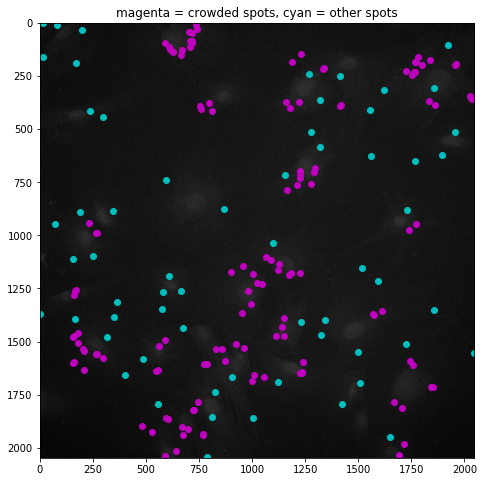

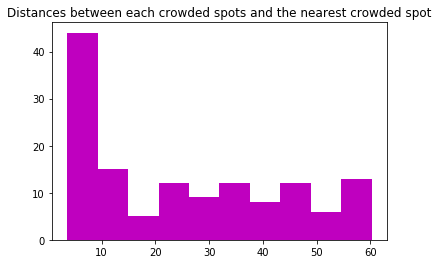

In [18]:
kdt = KDTree(blobs_list, leaf_size=2, metric='euclidean')

def get_nnd(coord, kdt):
    dist, ind = kdt.query([coord], k=2)
    return dist[0][1]

crosshair_arm_to_image_width_ratio = 0.03045   # measured empirically in Quantius's UI
crosshair_arm_length = crosshair_arm_to_image_width_ratio * img_width
print('crosshair_arm_length = ' + str(crosshair_arm_length))

plt.figure(figsize = (12, 8))
close_distances = []
crowded_spots = []
for coord in blobs_list:
    nnd = get_nnd(coord, kdt)
    if nnd < crosshair_arm_length:
        close_distances.append(nnd)
        crowded_spots.append(coord)
        plt.scatter(coord[0], coord[1], facecolors = 'm')
    else:
        plt.scatter(coord[0], coord[1], facecolors = 'c')

print('crowded spots / total spots = ' + str(len(crowded_spots)) + ' / ' + str(len(coords)) + ' = ' + str(round((float(len(crowded_spots))/len(coords)), 2)) + ' %')
        
plt.title('magenta = crowded spots, cyan = other spots')
plt.imshow(im, cmap='gray')
plt.show()
plt.hist(close_distances, color = 'm')
plt.title('Distances between each crowded spots and the nearest crowded spot')
plt.show()

## Goal 2: Separate regions with many crowded spots.

Use AffinityPropagation on crowded spots to separate out regions with many crowded spots. Smaller preference parameter results in fewer separated regions.

In [23]:
pref_param = -5000000
crowded_coords = np.asarray(crowded_spots)
af = AffinityPropagation(preference = pref_param).fit(crowded_coords)
centers = [crowded_coords[index] for index in af.cluster_centers_indices_]
print(centers)

[array([1760., 1610.]), array([ 271., 1557.]), array([ 964., 1532.]), array([1181.,  401.]), array([1833.,  366.]), array([667., 149.])]


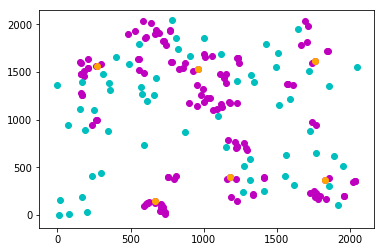

In [24]:
for coord in blobs_list:
    nnd = get_nnd(coord, kdt)
    if nnd < crosshair_arm_length:
        plt.scatter(coord[0], coord[1], facecolors = 'm')
    else:
        plt.scatter(coord[0], coord[1], facecolors = 'c')
for center in centers:
    plt.scatter(center[0], center[1], facecolors = 'orange')
plt.show()

## Goal 3: Define a bounding box around each region with many crowded spots.

In [25]:
cluster_members_lists = [[] for i in range(len(centers))]
for label_index, coord in zip(af.labels_, crowded_coords):
    cluster_members_lists[label_index].append(coord)

crop_bounds = []
for l in cluster_members_lists:
    l = np.asarray(l)
    x = l[:,0]
    y = l[:,1]
    crop_bounds.append((min(x), max(x), min(y), max(y)))
print(crop_bounds)

[(1569.0, 1851.0, 1358.0, 2032.0), (156.0, 604.0, 942.0, 2037.0), (640.0, 1242.0, 1104.0, 2014.0), (1158.0, 1417.0, 145.0, 786.0), (1726.0, 2037.0, 162.0, 973.0), (592.0, 811.0, 11.0, 412.0)]


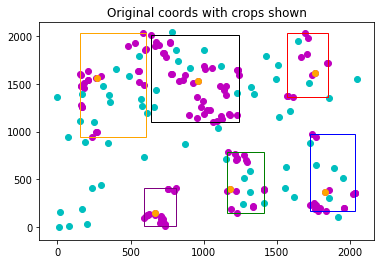

In [26]:
from matplotlib.patches import Rectangle
fig,ax = plt.subplots(1)
for coord in blobs_list:
    nnd = get_nnd(coord, kdt)
    if nnd < crosshair_arm_length:
        ax.scatter(coord[0], coord[1], facecolors = 'm')
    else:
        ax.scatter(coord[0], coord[1], facecolors = 'c')
for center in centers:
    plt.scatter(center[0], center[1], facecolors = 'orange')

colors = ['red', 'orange', 'black', 'green', 'blue', 'purple', 'violet', 'cyan']
for crop, col in zip(crop_bounds, colors):
    rect = Rectangle((crop[0], crop[2]), crop[1]-crop[0], crop[3]-crop[2], edgecolor = col, facecolor = 'none')
    ax.add_patch(rect)
plt.title('Original coords with crops shown')
plt.show()

-------------------------------------------------
Crop 0
crosshair_arm_length = 8.5869
crowded spots / total spots = 0 / 9 = 0.0 %


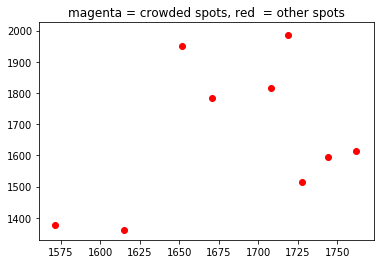

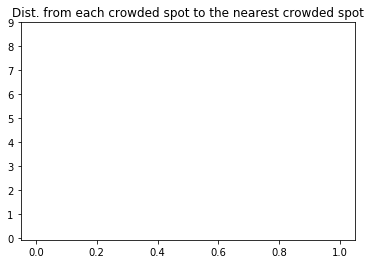

-------------------------------------------------
Crop 1
crosshair_arm_length = 13.6416
crowded spots / total spots = 6 / 30 = 0.2 %


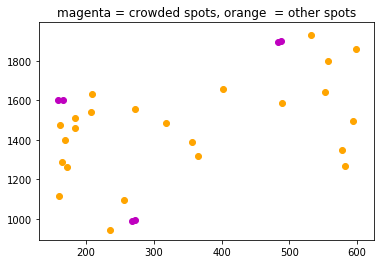

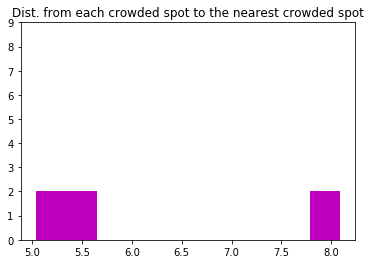

-------------------------------------------------
Crop 2
crosshair_arm_length = 18.3309
crowded spots / total spots = 16 / 53 = 0.3 %


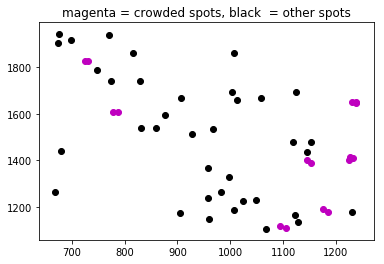

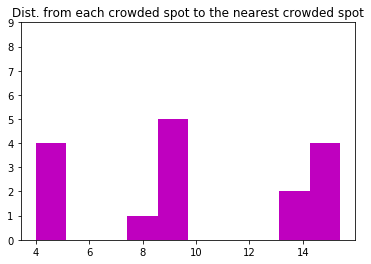

-------------------------------------------------
Crop 3
crosshair_arm_length = 7.886550000000001
crowded spots / total spots = 4 / 20 = 0.2 %


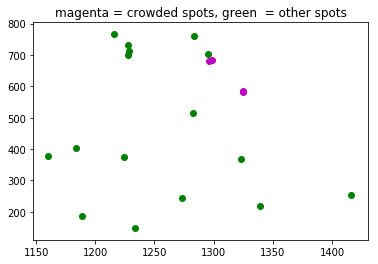

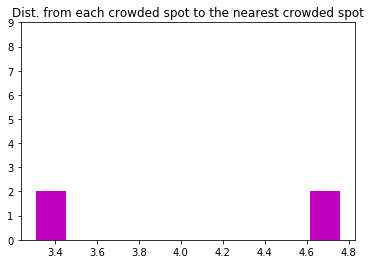

-------------------------------------------------
Crop 4
crosshair_arm_length = 9.46995
crowded spots / total spots = 8 / 21 = 0.38 %


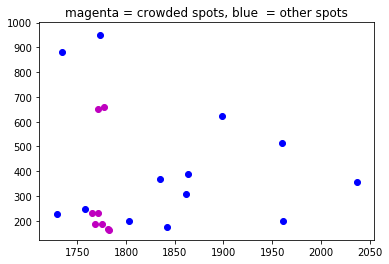

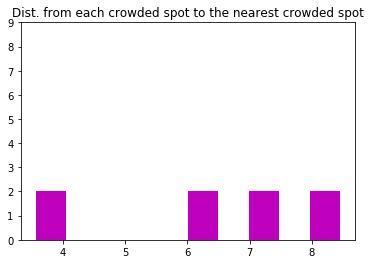

-------------------------------------------------
Crop 5
crosshair_arm_length = 6.668550000000001
crowded spots / total spots = 0 / 20 = 0.0 %


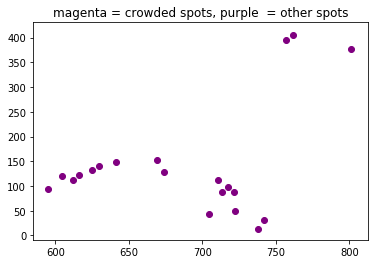

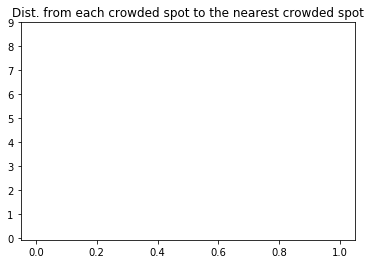

In [27]:
for i in range(len(crop_bounds)):
    print('-------------------------------------------------')
    print('Crop ' + str(i))
    
    crop = crop_bounds[i]
    col = colors[i]
    xmin = crop[0]
    xmax = crop[1]
    ymin = crop[2]
    ymax = crop[3]
    crop_width = crop[1]-crop[0]
    crosshair_arm_length = crosshair_arm_to_image_width_ratio * crop_width
    print('crosshair_arm_length = ' + str(crosshair_arm_length)) 
    
    crop_coords = []
    for coord in coords:
        if coord[0] >= xmin and coord[0] <= xmax:
            if coord[1] >= ymin and coord[1] <= ymax:
                crop_coords.append(coord)
                
    crop_kdt = KDTree(crop_coords, leaf_size=2, metric='euclidean')
    
    close_distances = []
    crowded_spots = []
    for coord in crop_coords:
        nnd = get_nnd(coord, crop_kdt)
        if nnd < crosshair_arm_length:
            close_distances.append(nnd)
            crowded_spots.append(coord)
            plt.scatter(coord[0], coord[1], facecolors = 'm')
        else:
            plt.scatter(coord[0], coord[1], facecolors = col)
    
    print('crowded spots / total spots = ' + str(len(crowded_spots)) + ' / ' + str(len(crop_coords)) + ' = ' + str(round((float(len(crowded_spots))/len(crop_coords)), 2)) + ' %')
    
    plt.title('magenta = crowded spots, ' + str(col) + '  = other spots')
    plt.show()
    plt.hist(close_distances, color = 'm')
    plt.yticks(np.arange(0, 10, step=1))
    plt.title('Dist. from each crowded spot to the nearest crowded spot')
    plt.show()